# <a id='toc1_'></a>[Introduction](#toc0_)

This notebook takes the conserved BMI network produced in Notebook 1 and generates a hierarchical systems map of protein communities. The systems map is annotated using GO enrichment to identify conserved functions underlying BMI in humans and rats. We validate the role of protein communities by examining the phenotypic response in mice upon genetic perturbation.

**Figures produced in this notebook:**
* *Figure 3B*. Volcano plots showing communities in the cross-species system map that are enriched for body size genes in mice
* *Figure 3D*. Source of MGD-validated genes by for body-size enriched communities
* *Figure 4*. Validation heat map for annotated communities
* *Figure 5B*. Validation heat map for unannotated communities

**Additional Visualizations**  
* All visualizations of the network, hierarchy and communities can be found in the accompanying Cytoscape file.

**Note on re-running the analysis:**
* If `rerun_analysis==True` (default) this notebook will load precomputed values for the hierarchy including the structure, annotations and mouse phenotype enrichment 
* If `rerun_analysis==False` this notebook will rerun all  steps. Note that due to stochasticity in some methods and changes to public datasets over time the results generated my differ slightly from those presented.

In [10]:
rerun_analysis=False

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Set Up](#toc2_)    
  - [Load input gene sets and interaction network](#toc2_1_)    
  - [Load the conserved BMI network](#toc2_2_)    
- [Hierarchical Community Detection with HiDeF](#toc3_)    
- [Community Annotation](#toc4_)    
  - [Seed gene fractions](#toc4_1_)    
  - [Initial Annotation with GO](#toc4_2_)    
  - [Manual curation of GO terms](#toc4_3_)    
- [Validation](#toc5_)    
  - [Load Mouse Genome Database (MGD) data](#toc5_1_)    
    - [Body size phenotype terms](#toc5_1_1_)    
  - [Identify genes associated with body size phenotypes in MGD](#toc5_2_)    
    - [Supplemental Table 7](#toc5_2_1_)    
  - [Perform enrichment of Mammalian Phenotypes](#toc5_3_)    
  - [Identify communities enriched for BMI-relevant phenotypes](#toc5_4_)    
    - [Figure 3B](#toc5_4_1_)    
  - [Annotation of GSR Community](#toc5_5_)    
  - [Source of validated genes within enriched communities](#toc5_6_)    
    - [Figure 3D](#toc5_6_1_)    
  - [Significant communities in annotated BMI systems map](#toc5_7_)    
  - [Endophenotypes of BMI-relevant communities](#toc5_8_)    
    - [Figure 4](#toc5_8_1_)    
    - [Example 1: GPCR Signaling & Response Regulation (GSR)](#toc5_8_2_)    
    - [Example 2: Muscle System & Calcium Signaling (MSC)](#toc5_8_3_)    
    - [Example 2: Demethylation (DM1)](#toc5_8_4_)    
    - [Example 4: Regulation of Phosphatase Activity (RPA)](#toc5_8_5_)    
    - [Example 5: Activation of MAPK](#toc5_8_6_)    
  - [Phenotypes associated with unannotated communties](#toc5_9_)    
    - [Figure 5B](#toc5_9_1_)    
    - [C933](#toc5_9_2_)    
    - [C914](#toc5_9_3_)    
    - [C908](#toc5_9_4_)    
    - [C921](#toc5_9_5_)    
- [Scaled Figures](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Set Up](#toc0_)

In [11]:
# load required libraries
import os
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

In [2]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/rerun_")

In [12]:
# Import functions specific to this study
sys.path.append(cwd)
from updated_netcoloc_functions import *
from analysis_functions import *
from plotting_functions import *

## <a id='toc2_1_'></a>[Load input gene sets and interaction network](#toc0_)

In [13]:
## Load the final seed gene lists
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_genes.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [16]:
# If you receive a connection error, please retry.
pc_nodes, G_PC = load_pcnet()

number of nodes:
18820

number of edges:
2693109


## <a id='toc2_2_'></a>[Load the conserved BMI network](#toc0_)

Note: the conserved network will remain private until publication. As an alternative to importing the network from NDEx it can be loaded from a stored file below (Note: this network does not include nodes that are not part of the largest connected component). 

In [117]:
## Uncomment to load edgelist from file
#G_BMI_coloc_edgelist = pd.read_csv(DATADIR + "outputs/conserved_network_edgelist.tsv", sep="\t", index_col=0)
#G_BMI_coloc = nx.from_pandas_edgelist(G_BMI_coloc_edgelist, source="source", target="target")
#print('number of nodes:', len(G_BMI_coloc.nodes))
#print('\nnumber of edges:', len(G_BMI_coloc.edges))

In [17]:
# import the conserved network
ndex_server='public.ndexbio.org'
ndex_user=getpass("Username:")
ndex_password=getpass("Password:")
G_BMI_coloc_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='bdc44778-2b18-11ed-ac45-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_BMI_coloc = G_BMI_coloc_cx.to_networkx()
print('number of nodes:', len(G_BMI_coloc.nodes))
print('\nnumber of edges:', len(G_BMI_coloc.edges))

number of nodes: 657

number of edges: 5287


# <a id='toc3_'></a>[Hierarchical Community Detection with HiDeF](#toc0_)

**Note:** if `rerun_analysis==True` the communities may not exactly match those in the reported analysis as the hierarchical community detection process is not deterministic. 

In [18]:
# perform heirarchical community detection
if rerun_analysis:
    cd = cdapsutil.CommunityDetection()
    G_BMI_hier = cd.run_community_detection(G_BMI_coloc_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'10'})
    # Print information about hierarchy
    print('Hierarchy name: ' + str(G_BMI_hier.get_name()))
    print('# nodes: ' + str(len(G_BMI_hier.get_nodes())))
    print('# edges: ' + str(len(G_BMI_hier.get_edges())))
    G_BMI_hier = G_BMI_hier.to_networkx()
    BMI_hier_df = pd.DataFrame.from_dict(dict(G_BMI_hier.nodes(data=True)), orient="index")
    #hier_df_genes = hier_df.loc[:, ["CD_MemberList", "frac_d1_seeds", "frac_d2_seeds"]]
else:
    BMI_hier_df = pd.read_csv(DATADIR+ "outputs/BMI_hierarchy_data.tsv", sep="\t", index_col=0)

# <a id='toc4_'></a>[Community Annotation](#toc0_)

## <a id='toc4_1_'></a>[Seed gene fractions](#toc0_)

In [19]:
# Get fractions of seed genes
seed_fractions = get_seed_gene_fractions(BMI_hier_df, seed_bin_human_BMI, seed_bin_rat_BMI)
seed_fractions.to_csv(DATADIR+"outputs/BMI_hierarchy_community_seed_fractions.tsv", index=True, header=True, sep= "\t")
seed_fractions.head()

,overlap,h_seed,r_seed,CD_MemberList,network
C877,0.032710,0.320872,0.144860,1.0,0.501558
C878,0.037383,0.294393,0.130841,1.0,0.537383
C879,0.041420,0.295858,0.142012,1.0,0.520710
C880,0.012739,0.369427,0.159236,1.0,0.458599
C881,0.014706,0.441176,0.161765,1.0,0.382353


## <a id='toc4_2_'></a>[Initial Annotation with GO](#toc0_)

Annotate with moderately sized systems (between 50 to 1000 genes per system) if the community shows a significant ($p<1\times 10^{-4}$) enrichment for the term. Also require that the GO term and community and share at least 3 genes to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.

**Note:**  
Rerunning the annotation may generate slightly different results due to changes in the GO:BP database over time. The original results were generated January 18, 2022.

In [20]:
def filter_go_annotations(go_df, term_min=50, term_max=1000, p_th=1e-4, min_intersection=3):
    """Filters available annotations for a community based on specificity and significance.
    Args:
        go_df (pandas.DataFrame): All available significant GO terms for each community
        term_min (int, optional):   The minimum size of a term to keep. Defaults to 50.
        term_max (int, optional): The maximum size of a term to keep. Defaults to 1000.
        p_th (float, optional): The significance threshold. Defaults to 1e-4.
        min_intersection (int, optional): Minimum number of community terms annotated to the GO term. Defaults to 3.

    Returns:
        pandas.DataFrame: A filter dataframe of GO annotations per community, sorted by sum of precision and recall.
    """
    go_df = go_df[(go_df['term_size'] <= term_max) & (go_df['term_size'] >= term_min)]
    go_df = go_df[go_df['intersection_size'] >= min_intersection]
    go_df = go_df[go_df['p_value'] < p_th] # set a stringent pvalue threshold
    go_df['sum_PR'] = go_df['recall'] + go_df['precision']
    go_df = go_df.sort_values('sum_PR',ascending=False)
    return go_df

In [21]:
# Annotate with GO terms
# gprofiler annotation of clusters
if rerun_analysis:
    system_names = {}
    all_results = []
    for comm in BMI_hier_df.index.tolist():
        # get the genes in the community
        if isinstance(BMI_hier_df['CD_MemberList'].loc[comm], str):
            focal_genes=BMI_hier_df['CD_MemberList'].loc[comm].split(' ')
        else:
            focal_genes=BMI_hier_df['CD_MemberList'].loc[comm]
        print(comm,":", len(focal_genes))
        system_names[comm] = comm # default is to keep identifier as name, will be replaced if confident annotation available
        if len(focal_genes)>2:
            # get all available GO:BP annotations
            gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                                sources=['GO:BP'], no_evidences=False))
            if len(gp_temp)>0: # make sure data is not empty
                # filter and append the results
                gp_temp["community"] = comm
                all_results.append(gp_temp)
                gp_temp = filter_go_annotations(gp_temp, 50, 1000, 1e-3, 3)
                if len(gp_temp)>1:
                    system_names[comm] = gp_temp.head(1)['name'].tolist()[0]
                    #all_results.append(gp_temp)
    go_results = pd.concat(all_results)
    go_results.to_csv(DATADIR+"outputs/rerun_BMI_hierachy_full_GO_enrichment.tsv", index=True, sep="\t")
            
else:
    # load results from file and filter
    go_results = pd.read_csv(DATADIR+ "outputs/BMI_hierarchy_full_GO_enrichment.tsv", index_col=None, sep="\t")
    go_results = filter_go_annotations(go_results, 50, 1000, 1e-3, 3)
    system_names = {}
    for comm in BMI_hier_df.index.tolist():
        if comm in go_results['community'].tolist():
            system_names[comm] = go_results[go_results['community']==comm]['name'].tolist()[0]
        else:
            system_names[comm] = comm

In [22]:
system_names

{'C877': 'proteoglycan biosynthetic process',
 'C898': 'C898',
 'C904': 'negative regulation of transcription by RNA polymerase II',
 'C906': 'C906',
 'C911': 'C911',
 'C913': 'C913',
 'C914': 'C914',
 'C915': 'C915',
 'C924': 'C924',
 'C925': 'C925',
 'C926': 'C926',
 'C930': 'C930',
 'C931': 'regulation of small GTPase mediated signal transduction',
 'C933': 'C933',
 'C935': 'C935',
 'C937': 'C937',
 'C878': 'glycosaminoglycan biosynthetic process',
 'C880': 'C880',
 'C882': 'demethylation',
 'C885': 'negative regulation of cell differentiation',
 'C887': 'detection of chemical stimulus involved in sensory perception of smell',
 'C888': 'intracellular protein transport',
 'C889': 'MAPK cascade',
 'C890': 'C890',
 'C892': 'C892',
 'C895': 'C895',
 'C883': 'glycosaminoglycan biosynthetic process',
 'C879': 'calcium-ion regulated exocytosis',
 'C932': 'C932',
 'C901': 'C901',
 'C902': 'C902',
 'C907': 'muscle system process',
 'C909': 'negative regulation of phosphatase activity',
 'C88

## <a id='toc4_3_'></a>[Manual curation of GO terms](#toc0_)

The final annotations of the conserved BMI systems map were determined via manual curation of the significant GO terms. 

In [23]:
final_annotations = pd.read_csv(DATADIR+"outputs/BMI_hierarchy_curated_annotations.tsv", sep="\t", index_col=None)
final_annotations = final_annotations.set_index("community")
final_annotations

,annotation
community,
C877,Conserved BMI Network (root)
C878,Nervous System Development
C879,Synaptic Signaling
C880,Chromosome Organization
C881,mRNA Metabolic Process
...,...
C933,C933
C934,Transcription Initiation RNA Poly II
C935,C935


In [24]:
annotated_systems = final_annotations[final_annotations.index != final_annotations.annotation]
annotated_systems

,annotation
community,
C877,Conserved BMI Network (root)
C878,Nervous System Development
C879,Synaptic Signaling
C880,Chromosome Organization
C881,mRNA Metabolic Process
C882,Demethylation 1
C883,Glycosaminoglycan Biosynthetic Process
C884,Exocytosis
C885,Regulation of Cell Differentiation


# <a id='toc5_'></a>[Validation](#toc0_)


## <a id='toc5_1_'></a>[Load Mouse Genome Database (MGD) data](#toc0_)

**Note:** we use a stable version of MGD downloaded on April 24, 2022. If using an updated dataset, slight variations in results are expected due to recent data submission to MGD. 

In [25]:
# load mappings between genes and mammalian phenotypes
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt', 
                                map_using="mgi", update=False, data_loc=DATADIR+"Reference/")
print("Number of gene-phenotype associations:", len(mgi_df))

Number of gene-phenotype associations: 364548


**Node Updating**  
The gene symbols listed under human orthologs in the MGD are more up to date than the gene symbols in PCNet. Therefore, to ensure correct mapping of our conserved network to MGD we map the human ortholog column to the symbols in PCNet using MyGeneInfo. Some gene symbols return duplicate entries via MyGeneInfo which we resolved manually (see `symbol_list` below).

In [27]:
symbol_list = {'GARS': 'GARS1', 'GGT2': 'GGT2P','MARS': 'MARS1', 'HIST1H2BC': 'H2BC4', 'GBA': 'GBA1', 'HIST1H2BG': 'H2BC8',
'HIST1H2BF': 'H2BC7', 'HIST1H2BE': 'H2BC6', 'HIST1H2BI': 'H2BC10', 'CBWD3': 'ZNG1C', 'BHLHB9': 'GPRASP3', 'ELOA3': 'ELOA3P',
'ELOA3B': 'ELOA3BP', 'SMIM11B': 'SMIM11', 'CBSL': 'CBS', 'C2orf27B': 'CDRT15P3', 'LINC00846': 'TCP10L'}
updated_pc_nodes, _ = update_nodes(pc_nodes, symbol_list)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-18820...done.
Finished.
227 input query terms found dup hits:
	[('TCEA1P2', 2), ('USP12P1', 2), ('TBC1D29P', 2), ('RAB42P1', 2), ('WDR82P1', 3), ('FBXL21P', 2), ('
582 input query terms found no hit:
	['EEF1AKNMT', 'AC022826.2', 'TMEM189-UBE2V1', 'WRB', 'ARNTL', 'KIF1BP', 'TTC37', 'TMEM251', 'MARCH5'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-582...done.
Finished.
17 input query terms found dup hits:
	[('GARS', 2), ('GGT2', 2), (

In [28]:
# updated the genotype-phenotype identifiers
mgi_df = change_symbols(mgi_df, updated_pc_nodes)

In [29]:
# load the mammalian phenotype ontology
MPO = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', 
                        use_genes=True, mapping=mgi_df, data_loc=DATADIR+"Reference/", update=False)

14555


In [30]:
# summarize the total evidence per gene and term
term_counts, gene_mapping, term_mapping = genes_per_node(MPO)

In [31]:
# construct a graph object of the MPO
mp_graph = get_mp_graph(DATADIR+"Reference/parsed_mp.txt")

### <a id='toc5_1_1_'></a>[Body size phenotype terms](#toc0_)

We use the following terms to represent abnormal body size phenotypes in MGD:
* MP:0001697 - abnormal embryo size
* MP:0010866 - abnormal prenatal body size
* MP:0003956 - abnormal postnatal body size
* MP:0005451 - abnormal body composition

When looking within a specific community, we also consider the more specific terms:
* MP:0001261 - obese
* MP:0020182 - abnormal body mass index


In [35]:
body_size_terms = [num_to_mp(x) for x in [1697, 10866, 3956, 5451]]
obesity_bmi_terms = [num_to_mp(n) for n in [1261, 20182]]

## <a id='toc5_2_'></a>[Identify genes associated with body size phenotypes in MGD](#toc0_)

### <a id='toc5_2_1_'></a>[Supplemental Table 7](#toc0_)
For all genes in PCNet we construct a table summarizing whether each gene has been associated with body size traits in mice, as well as the seed gene status

In [32]:
# Assign the seed gene status of all genes    
table7 = pd.DataFrame({"gene":G_PC.nodes})
table7 = table7.assign(rat_seed = [1 if gene in seed_bin_rat_BMI else 0  for gene in table7.gene.values])
table7 = table7.assign(human_seed = [1 if gene in seed_bin_human_BMI else 0  for gene in table7.gene.values])
table7 = table7.assign(both_seed = [1 if (gene in seed_bin_human_BMI ) and (gene in seed_bin_rat_BMI) else 0  for gene in table7.gene.values])

In [33]:
# For all genes in the conserved BMI network, assign their source as seed genes or network-implicated
def assign_network(row):
    if row.both_seed == 1:
        return "Both"
    elif row.rat_seed == 1:
        return "Rat"
    elif row.human_seed == 1:
        return "Human"
    else:
        return "Network"
table7["Conserved_Source"] = table7.apply(lambda x: assign_network(x) if x.gene in list(G_BMI_coloc.nodes) else "", axis=1)
table7.Conserved_Source.value_counts()

           18163
Network      336
Human        207
Rat           93
Both          21
Name: Conserved_Source, dtype: int64

In [36]:
## Add MGD info body size phenotype information
for term in body_size_terms:
    genes = {MPO.genes[i] for i in term_mapping[term]}
    table7[term] = [1 if g in genes else 0 for g in table7.gene.values]

for term in obesity_bmi_terms:
    genes = {MPO.genes[i] for i in term_mapping[term]}
    table7[term] = [1 if g in genes else 0 for g in table7.gene.values]


In [37]:
# For each gene, indicate if it is associated with any of the 4 body size or 2 bmi/obesity phenotypes
table7["MGD:BodySize"] = table7.apply(lambda x: 1 if sum([x[term] for term in body_size_terms]) else 0, axis=1)
table7["MGD:Obesity/BMI"] = table7.apply(lambda x: 1 if sum([x[term] for term in obesity_bmi_terms]) else 0, axis=1)

In [38]:
# For each gene, indicate whether it has any phenotypes (normal or abnormal) in MGD
table7["InMGD"] = table7.gene.apply(lambda x: 1 if x in MPO.genes else 0)

In [40]:
table7.to_csv(DATADIR+ "outputs/Supplemental_Table7.tsv", sep="\t", index=False)

## <a id='toc5_3_'></a>[Perform enrichment of Mammalian Phenotypes](#toc0_)

In [41]:
if rerun_analysis:
    bmi_phenotypes = []
    # for each community, calculate the enrichment for all phenotypes
    for community in tqdm(BMI_hier_df.index):
        x = community_term_enrichment(community,  BMI_hier_df, MPO, mgi_df, term_counts, gene_mapping, G_int=G_PC)
        x = x.assign(name=community)
        bmi_phenotypes.append(x)
    bmi_pheno_results = pd.concat(bmi_phenotypes)
    bmi_pheno_results.to_csv(DATADIR + "outputs/rerun_BMI_hierarchy_full_MGD_enrichment_results.tsv", sep="\t")
else:
    bmi_pheno_results = pd.read_csv(DATADIR + "outputs/BMI_hierarchy_full_MGD_enrichment_results.tsv", sep = "\t", index_col=0)
    

In [42]:
# assign the community annotations
bmi_pheno_results = bmi_pheno_results.merge(final_annotations, left_on="name", right_index=True)

## <a id='toc5_4_'></a>[Identify communities enriched for BMI-relevant phenotypes](#toc0_)

In [43]:
# Identify the communties with at least one significant body size enrichment
comm_results_body_size = bmi_pheno_results.loc[body_size_terms].sort_values(by="OR_CI_lower", ascending=False)
comm_results_body_size["q"] = fdrcorrection(list(comm_results_body_size.OR_p.values), method="poscorr")[1]
comm_results_body_size["-log10p"] = comm_results_body_size.OR_p.apply(lambda x: -1 * np.log10(x))
comm_results_body_size["annotate"] = comm_results_body_size.apply(lambda x: x["name"] if (x["OR_p"] < 0.05)
                                                                    else "Other", axis=1)

In [51]:
# create a color palette for the body size enriched communities
my_palette = sns.color_palette("Set1").as_hex()[0:8] + [sns.color_palette("Set2").as_hex()[i] for i in [0, 2, 4,5,6]] + [sns.color_palette("Set3").as_hex()[i] for i in [9, 7, 3]] + [sns.color_palette("Set2").as_hex()[7]]

my_palette = [my_palette[i] for i in [ 12, 6, 0, 4, 11, 5, 10, 2, 8, 9,1, 3, 13, 14, 7, 16]]
#sns.color_palette(my_palette)

In [45]:
abbreviations = {"C877": "Root", "C889": "PP", "C917": "MAPK", "C882":"DM1", "C886": "DM2", "C900": "DM3", "C880": "CO",
                "C894": "GSR", "C909":"RPA", "C879":"SS", "C907": "MSC", "C921":"C921", "C914":"C914", "C933":"C933",
                "C908": "C908"}

In [52]:
comm_results_body_size["abbr"] = comm_results_body_size.apply(lambda x: abbreviations[x["name"]] if (x["name"] in abbreviations) and
                                                                (x["annotate"] != "Other")
                                                                else x["name"] if x["annotate"] != "Other" else "Other", axis=1)

In [50]:
comm_results_body_size[comm_results_body_size["name"]=="C906"]

,observed,total,OR,OR_p,OR_CI_lower,OR_CI_upper,hyper_p,sig_5e6,description,size,name,annotation,q,-log10p,annotate,abbr
MP:0003956,4,3464,3.549364,0.059074,0.952626,13.224479,0.013732,False,abnormal body size,9,C906,C906,0.222662,1.228606,Other,Other
MP:0005451,3,2927,2.716655,0.157716,0.679048,10.868475,0.038228,False,abnormal body composition,9,C906,C906,0.442269,0.802124,Other,Other


### <a id='toc5_4_1_'></a>[Figure 3B](#toc0_)

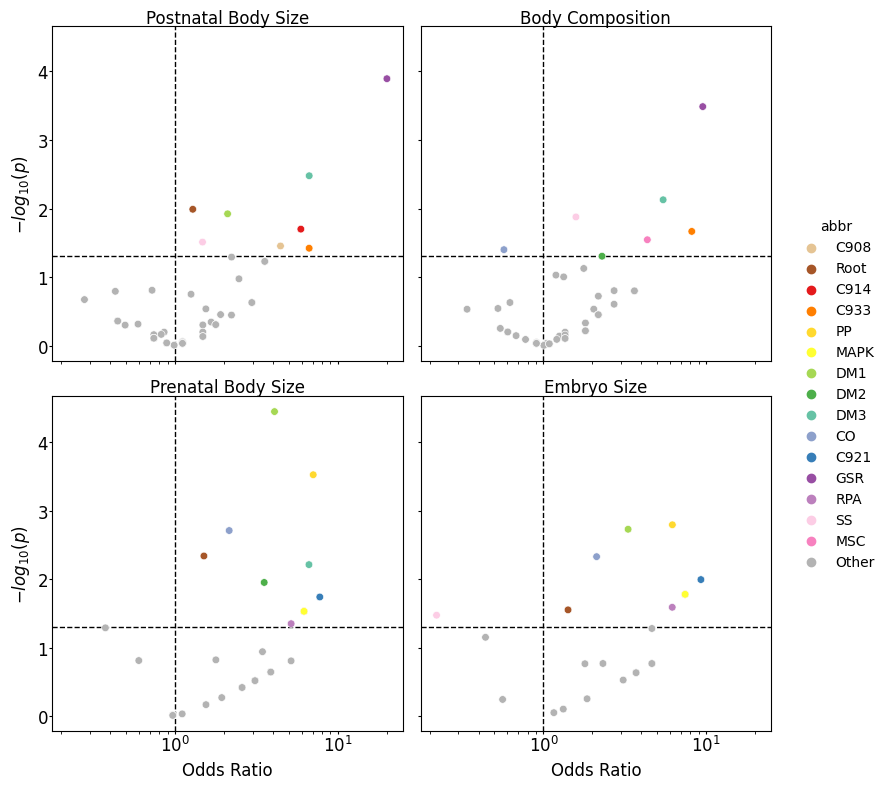

In [54]:
fg = sns.relplot(data=comm_results_body_size, x="OR", y="-log10p", col="description", hue="abbr",
                hue_order=["C908","Root","C914","C933","PP","MAPK","DM1", "DM2", "DM3","CO","C921","GSR",
                "RPA","SS","MSC", "Other"],
                legend="brief", palette=my_palette, col_wrap=2, height=4, s=30, facet_kws={"despine":False})
fg.set_titles(col_template="")
axs = fg.axes
plt.xscale("log")
titles = ["Postnatal Body Size","Body Composition", "Prenatal Body Size" , "Embryo Size"]
for i, ax in enumerate(axs):
    ax.axvline(1, color="black", linestyle="dashed", zorder=0, lw=1)
    ax.axhline(-1 * np.log10(0.05), color="black", linestyle="dashed", zorder=0, lw=1)
    ax.tick_params(axis='y', pad=1, length=2, labelsize=12)
    ax.tick_params(axis='x', pad=1, length=2, labelsize=12)
    ax.set_ylabel("$-log_{10}(p)$", fontsize=12)
    ax.set_xlabel("Odds Ratio", fontsize=12)
    ax.set_title(titles[i], fontsize=12, pad=2)

fg.tight_layout()
plt.savefig(FIGDIR + "rerun_"*rerun_analysis + "3b_MGD_erichment_volcano_plots.png", dpi=400, bbox_inches="tight")

## <a id='toc5_5_'></a>[Annotation of GSR Community](#toc0_)

In [55]:
# list of GSR genes obesity/bz
obesity_bmi_genes = set()
for term in obesity_bmi_terms:
    obesity_bmi_genes = obesity_bmi_genes.union({MPO.genes[i] for i in term_mapping[term]})
body_size_genes = set()
for term in body_size_terms:
    body_size_genes = body_size_genes.union({MPO.genes[i] for i in term_mapping[term]})
    
gsr = pd.DataFrame({"Obesity":["Y" if gene in obesity_bmi_genes else "" for gene in BMI_hier_df.loc["C894"]["CD_MemberList"]],
                    "Body Size":["Y" if gene in body_size_genes else "" for gene in BMI_hier_df.loc["C894"]["CD_MemberList"]]}
                    , index=BMI_hier_df.loc["C894"]["CD_MemberList"])
gsr.sort_index()

,Obesity,Body Size
ADORA2B,,
BDNF,Y,Y
C12orf42,,
GNAI2,,Y
GNAO1,,Y
MC4R,Y,Y
NPFFR1,,Y
POMC,Y,Y
POU1F1,,Y
PRLHR,,Y


## <a id='toc5_6_'></a>[Source of validated genes within enriched communities](#toc0_)

In [58]:
# create list of significant communities
sig_communities = ["C877", "C879", "C894", "C907", "C909", "C889", "C917", "C882", 
                    "C886", "C900", "C880", "C921", "C914", "C933", "C908"][::-1]

In [60]:
# identify the proportion of validated genes within each communities per source for a stacked bar plot
stack = {}
for comm in BMI_hier_df.index:
    genes = BMI_hier_df.loc[comm].CD_MemberList
    comm_df = table7[table7.gene.isin(genes)]
    stack[comm] = comm_df.groupby("Conserved_Source")["MGD:BodySize"].sum()/comm_df.InMGD.sum()
stack = pd.DataFrame.from_dict(stack).T
# sort the data for plotting
stack["sum"] = stack.apply(lambda x: np.nansum([x.Rat, x.Both, x.Human, x.Network]), axis=1)
stack = stack.sort_values(by="sum", ascending=True)
plot_order =list(stack.index.drop("C877")) + ["C877"]
stack = stack.loc[plot_order]
stack = stack.loc[:, ("Both", "Human", "Rat", "Network", "sum")]

### <a id='toc5_6_1_'></a>[Figure 3D](#toc0_)

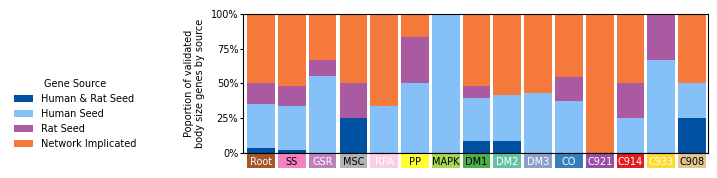

In [65]:
# create a stacked bar plot showing the network sources of validated community genes
_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 2), sharex=True, 
                            gridspec_kw={'height_ratios':(0.9, 0.1), 'hspace':0})
plot_data = stack
for col in ["Both", "Human", "Rat", "Network"]:
    plot_data[col] = plot_data[col] / plot_data["sum"]
plot_data["sum"] = 1
plt.sca(ax1)
color_map={"Human":'#85c0f9', "Rat":'#a95aa1', "Network":"#f5793a", "Both": "#0051a2"}
plot_data[plot_data.index.isin(sig_communities[::-1])].drop(columns="sum").loc[sig_communities[::-1]].plot(kind='bar', stacked=True, ax=ax1, color=color_map, width=0.9)

ax1.set_yticks([0, 0.25, 0.5, 0.75, 1], labels=["0%", "25%", "50%","75%", "100%"], fontsize=7)
ax1.legend(fontsize=7, frameon=False, title="Gene Source", title_fontsize=7, loc=(-0.5, 0), labels=["Human & Rat Seed", "Human Seed", "Rat Seed", "Network Implicated"])
ax1.set_ylabel("Poportion of validated\nbody size genes by source", fontsize=7)
_ = ax1.set_xlabel("             BMI Systems Map Communities", rotation=0, ha="left", y=1, fontweight="bold", fontsize=7)
ax1.set_ylim((0,1))
ax1.tick_params(pad=1, length=2, labelsize=7)
# Make annotation bar
plt.sca(ax2)
hue_order = ["C908","Root","C914","C906","C933","PP","MAPK","DM1", "DM2", "DM3","CO","C921","GSR",
            "RPA","SS","MSC", "Other"]
color_idx = [hue_order.index(abbreviations[lab]) for lab in sig_communities[::-1]]
plt.bar(x=[i for i in range(15)], height=1,width=0.9, color= [my_palette[i] for i in color_idx])
ax2.tick_params(length=0)
ax2.spines[["right", 'bottom', 'left']].set_visible(False)
ax2.set_yticks([])
for i, lab in enumerate(sig_communities[::-1]):
    if abbreviations[lab] in ["PP", "MAPK", "C908", "SS", "MSC", "DM1"]:
        label_color="black"
    else:
        label_color="white"
    ax2.annotate(abbreviations[lab], xy=(i, 0.2), fontsize=7, color=label_color, ha='center')
_ = ax1.set_xticklabels([])
plt.xlim(-0.6, 14.5)
plt.savefig(FIGDIR + "3d_validation_stacked_bar.png", dpi=600, bbox_inches="tight")

## <a id='toc5_7_'></a>[Significant communities in annotated BMI systems map](#toc0_)

We visualize the enrichments for body size traits across the system by showing the log2(OR) for any system-trait pair with a lenient p-value < 0.05. We use this cutoff just to prioritize systems for more detailed investigation, including enrichment for more specific body size phenotypes.

In [66]:
# extract just the systems that were functionally annotated above
system_map_results = comm_results_body_size[comm_results_body_size["name"].isin(annotated_systems.index)]

In [67]:
# order the systems to match the hierarchy layout
node_list = ["C894", "C891", "C884", "C879", "C907", "C909", "C878", "C883", "C912", "C885",
            "C887", "C917", "C889", "C931", "C882", "C886", "C900", "C904", "C888", "C929",
            "C880", "C934", "C920", "C881", "C905", "C899", "C918"]

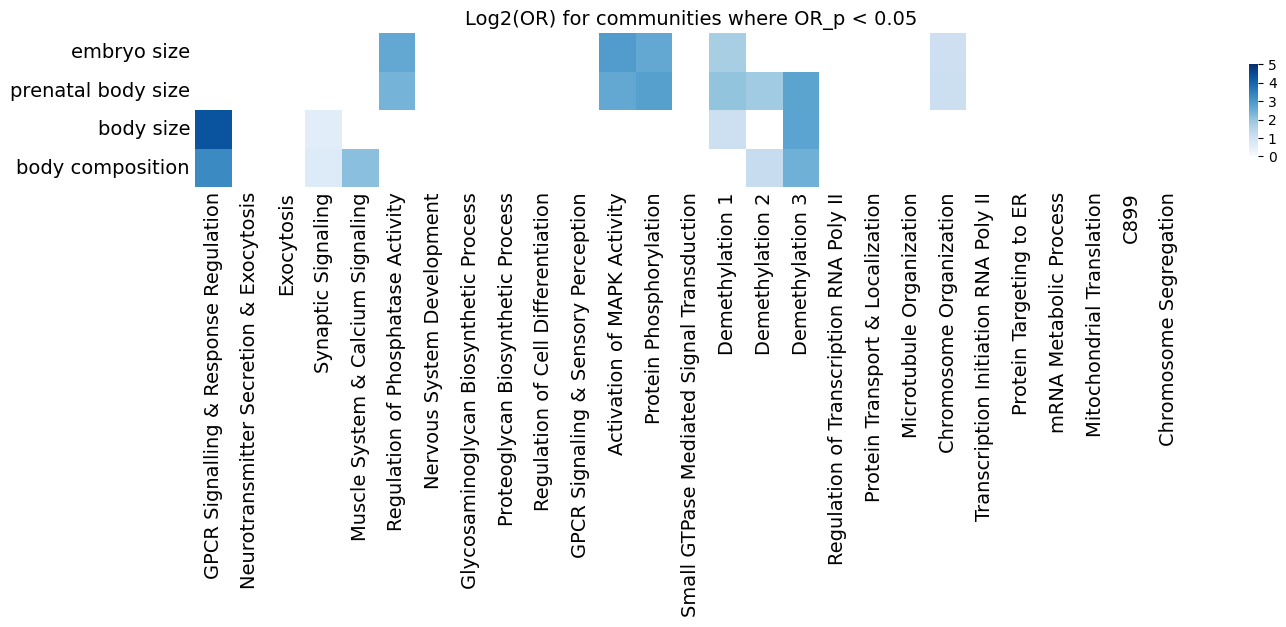

In [68]:
_ = plot_community_heatmap(system_map_results, body_size_terms, node_list, annotations=final_annotations, stat="OR", filter_stat="OR_p", 
                    color_range = [0, 5], MPO=MPO, vert = 2, horz=16, xlabel="annotation", filter_th=0.05)

Secondly, we identify all communities in the full 61-community system map showing a significant enrichment for at least one body size trait with q < 0.1. This table displays the corresponding odds ratio.  We see a number of un-annotated communities that show a significant enrichment for one or more body size phenotype:
* C933
* C914
* C908
* C921

In [69]:
comm_results_body_size[comm_results_body_size.OR_p < 0.05].pivot("annotation", "description", "OR").sort_values(by=["abnormal body composition", 
                                                                                                                "abnormal body size",
                                                                                                                "abnormal prenatal body size"], ascending=False)

description,abnormal body composition,abnormal body size,abnormal embryo size,abnormal prenatal body size
annotation,,,,
GPCR Signalling & Response Regulation,9.522517,19.997974,NaN,NaN
C933,8.152018,6.654435,NaN,NaN
Demethylation 3,5.437372,6.659341,NaN,6.636660
Muscle System & Calcium Signaling,4.348409,NaN,NaN,NaN
Demethylation 2,2.289753,NaN,NaN,3.522628
Synaptic Signaling,1.582618,1.471760,0.220212,NaN
Chromosome Organization,0.571373,NaN,2.120478,2.146357
C914,NaN,5.916378,7.422453,6.189492
C908,NaN,4.436994,NaN,NaN


## <a id='toc5_8_'></a>[Endophenotypes of BMI-relevant communities](#toc0_)

The MGD mutant collection also allows us to identify "endophenotypes" underlying the relationships between protein communities and body size phenotypes. Here we summarize the high level enrichments across the body size enriched communities within the heirarchy. Terms are selected to cover the key phenotypes impacted by the significantly enriched communities.

In [70]:
size = [1697, 10866 ] + [ 3956, 5451] # body size phenotypes
skel = [8395] # skeleton phenotypes
cell = [5076, 313] # cellular phenotypes
neo = [2019] # neoplasm phenotypes
ag = [8762, 10770] # Aging phenotypes
cardio = [2925, 10630, 4215] # Cardiovascular phenotypes
muscle = [759, 4087, 2269] # Muscle phenotypes
homeostasis = [5164, 3953, 2078] # Homeostasis and Metabolism phenotypes
exo = [2164, 2163] # Exocrine gland phenotypes
behavior = [14114,2069, 2066,  2067] # Behaviour phenotypes
nervous = [4811, 8946,2152,3861] # Nervous system phenotypes
all_terms = size+skel +cell +neo+ag +cardio + muscle + homeostasis + exo + behavior+nervous
all_terms = [num_to_mp(term) for term in all_terms]

all_groups = []
for i, term_list in enumerate([size, skel, cell,neo,ag, cardio, muscle, homeostasis, exo, behavior, nervous]):
    all_groups += [i%2]*len(term_list)


### <a id='toc5_8_1_'></a>[Figure 4](#toc0_)

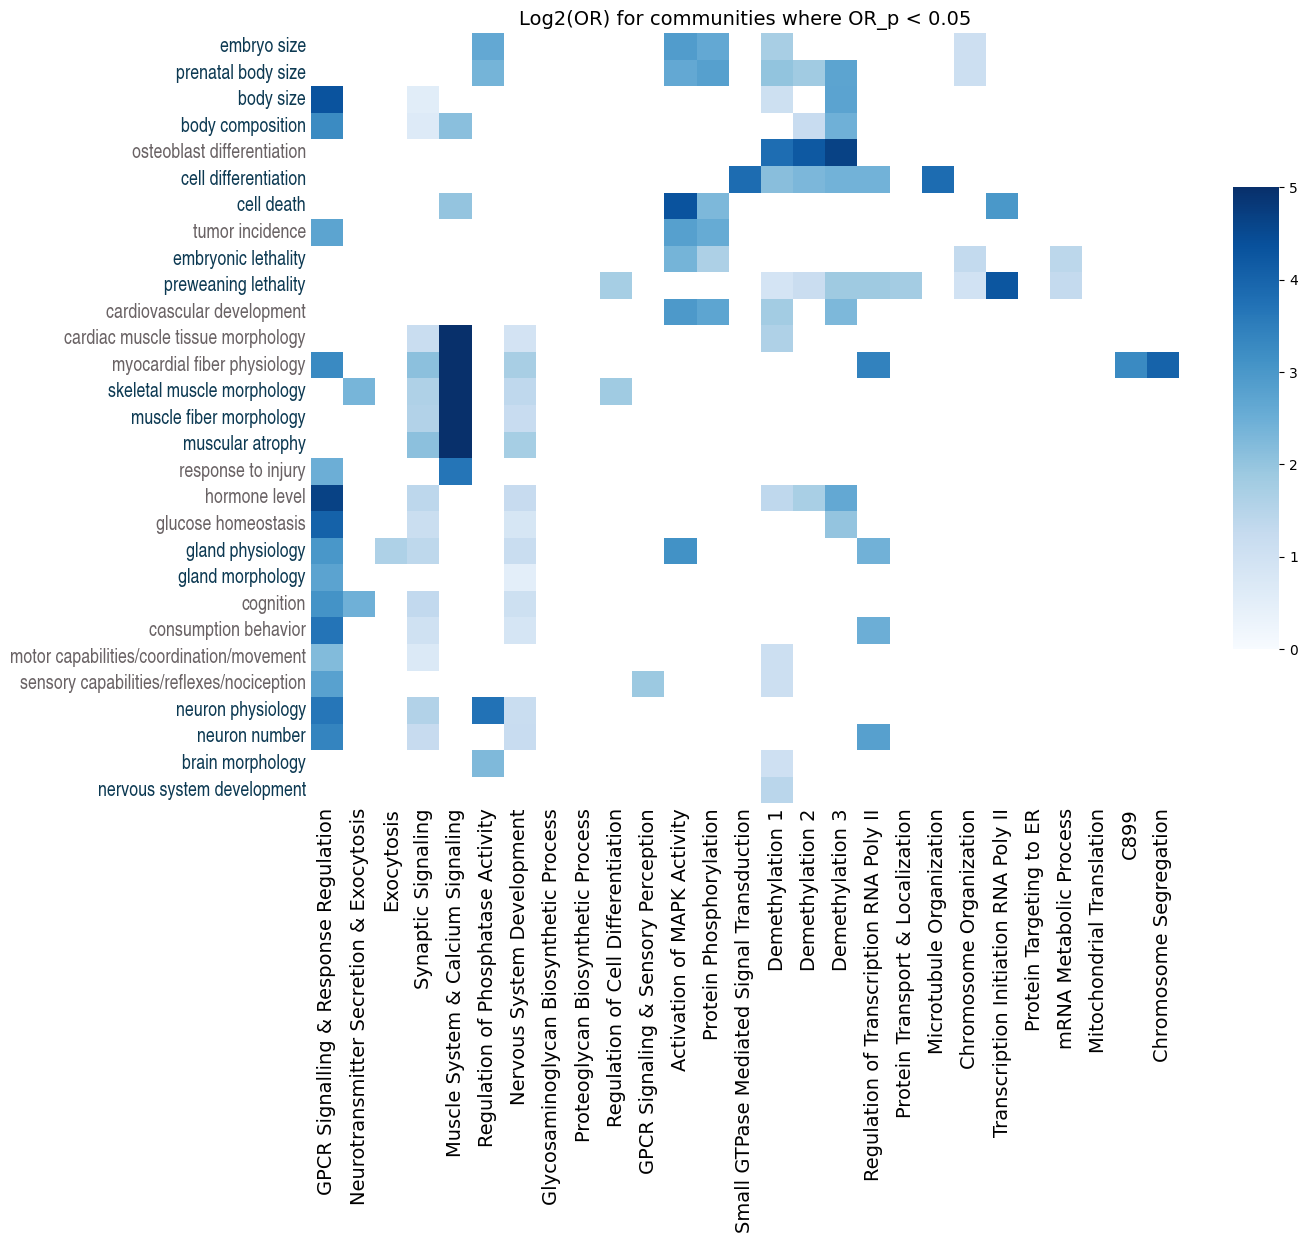

In [71]:
_ = plot_community_heatmap(bmi_pheno_results, all_terms, node_list, annotations=final_annotations, 
                            stat="OR", filter_stat="OR_p", color_range = [0, 5], MPO=MPO, 
                            vert = 10, horz=14, xlabel="annotation", filter_th=0.05,
                            ylabel_groups=all_groups)
plt.savefig(FIGDIR+"rerun_"*rerun_analysis + "4_hierarchy_full_heatmap.png", dpi=400, bbox_inches="tight")

### <a id='toc5_8_2_'></a>[Example 1: GPCR Signaling & Response Regulation (GSR)](#toc0_)

PARENT: MP:0000001 mammalian phenotype


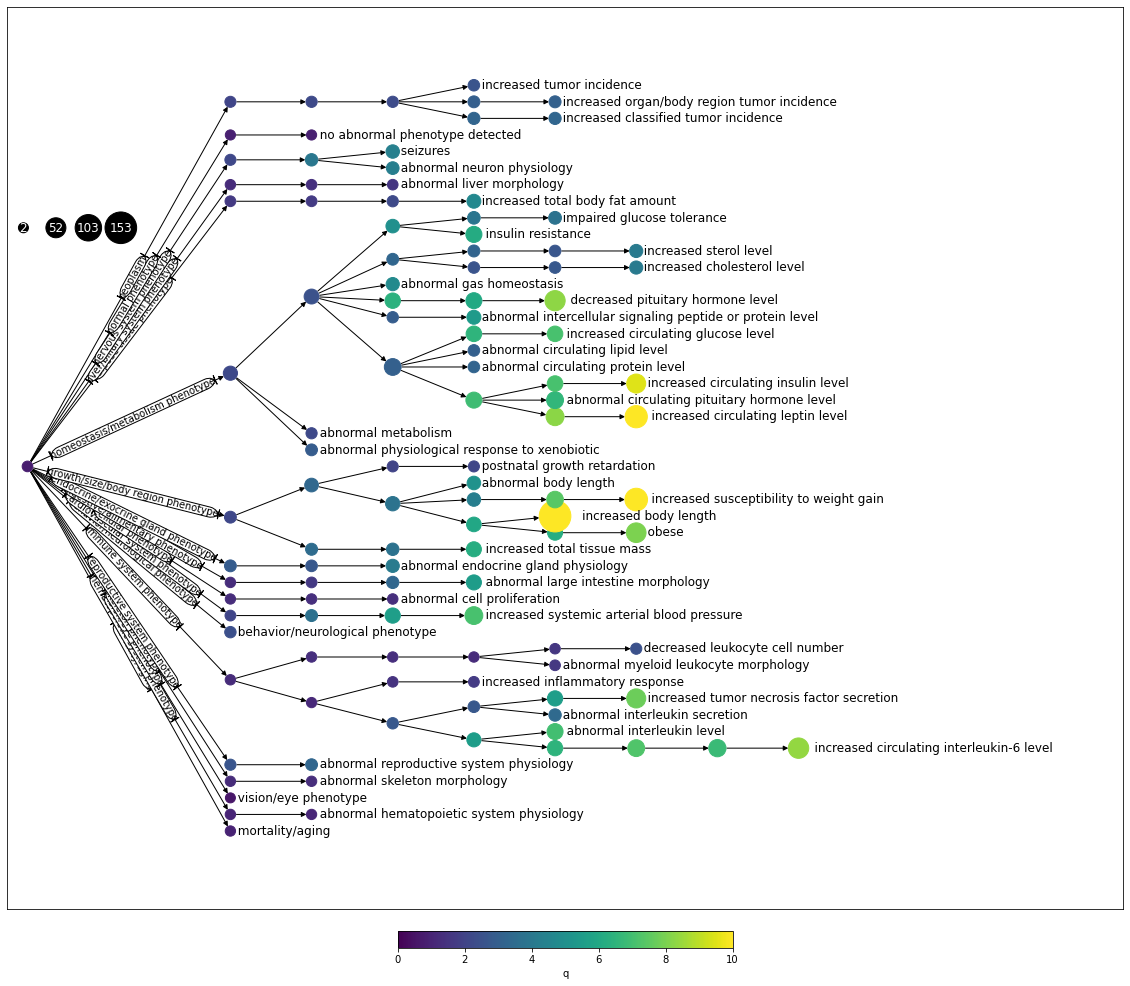

In [72]:
%matplotlib inline
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=3], "C894", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by=None,color_by="q", vert=20, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

In [73]:
mp = "MP:0004811"
print(bmi_pheno_results[bmi_pheno_results["name"]=="C894"].loc[mp, "OR"])
bmi_pheno_results[bmi_pheno_results["name"]=="C894"].loc[mp, "OR_p"]

12.503997219325688


5.729828999728345e-05

### <a id='toc5_8_3_'></a>[Example 2: Muscle System & Calcium Signaling (MSC)](#toc0_)

PARENT: MP:0000001 mammalian phenotype


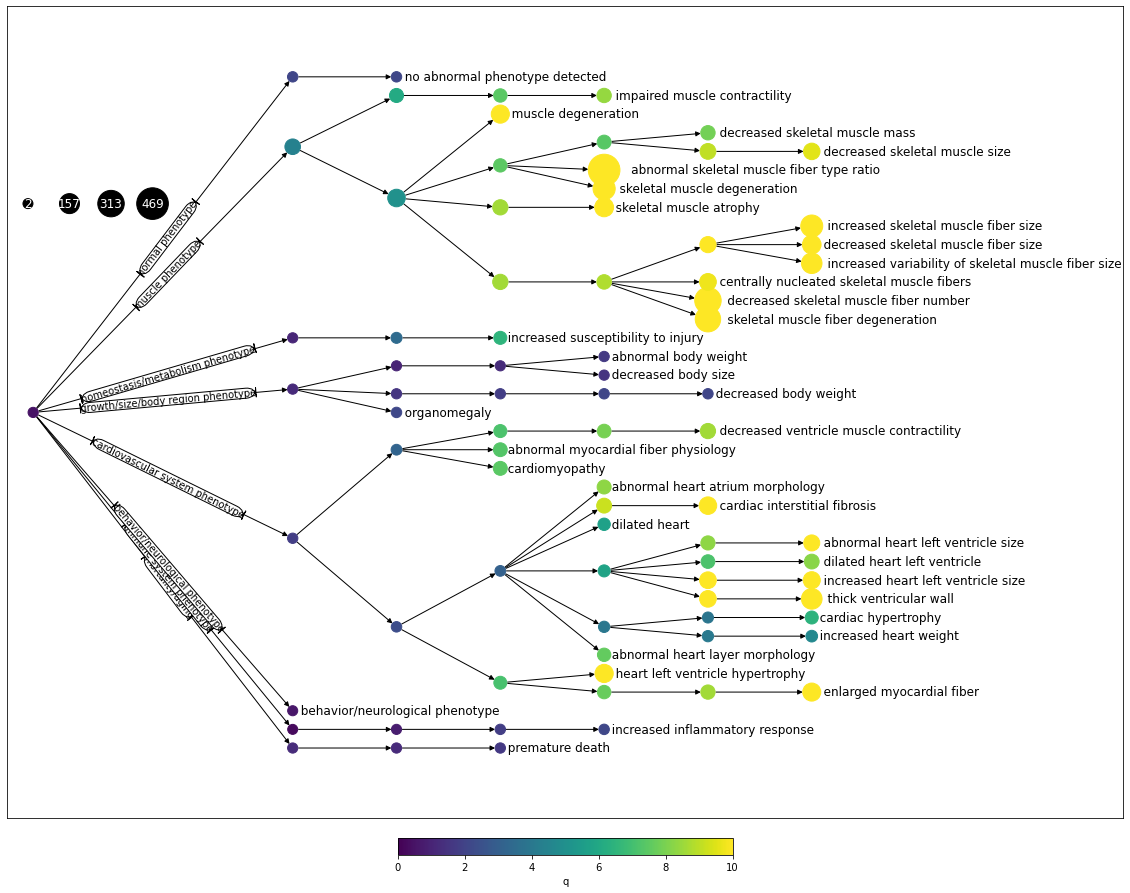

In [74]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=3], "C907", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="x",color_by="q", vert=18, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### <a id='toc5_8_4_'></a>[Example 2: Demethylation (DM1)](#toc0_)

PARENT: MP:0000001 mammalian phenotype


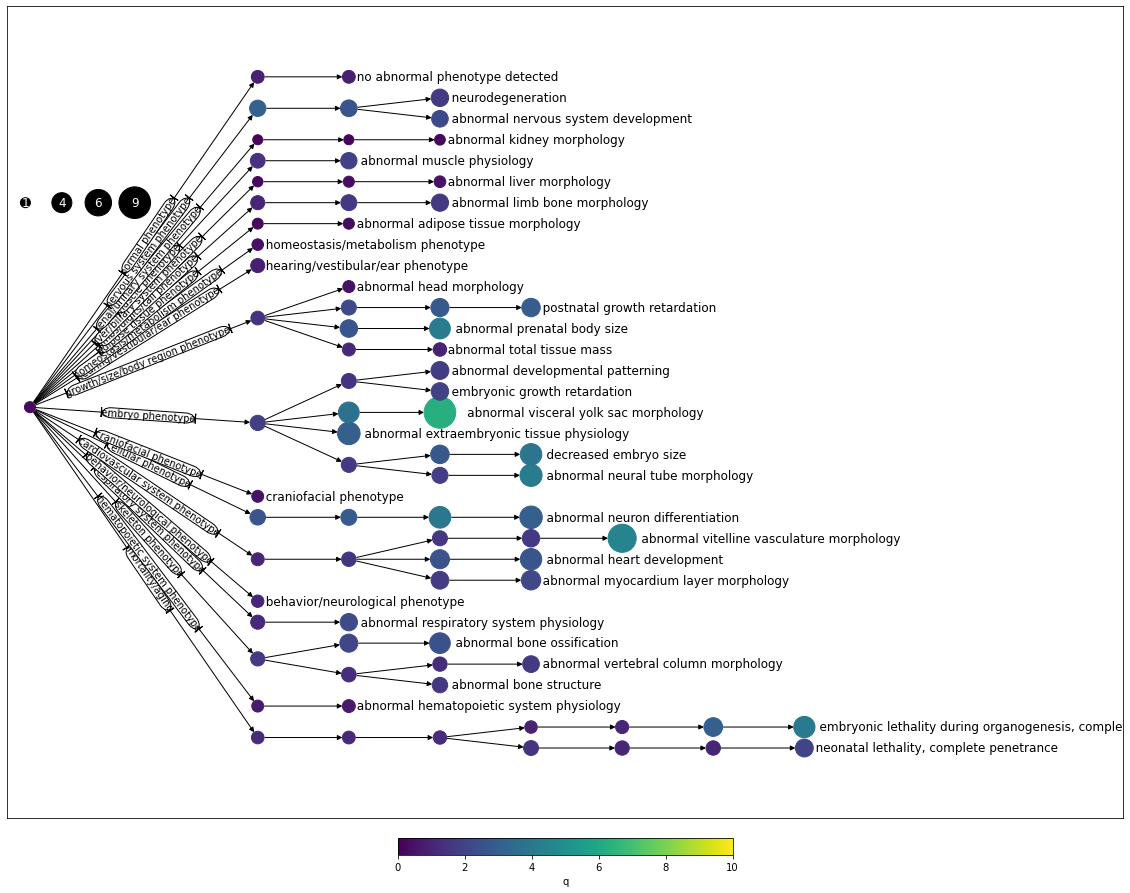

In [75]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=5], "C882", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="x",color_by="q", vert=18, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### <a id='toc5_8_5_'></a>[Example 4: Regulation of Phosphatase Activity (RPA)](#toc0_)

PARENT: MP:0000001 mammalian phenotype


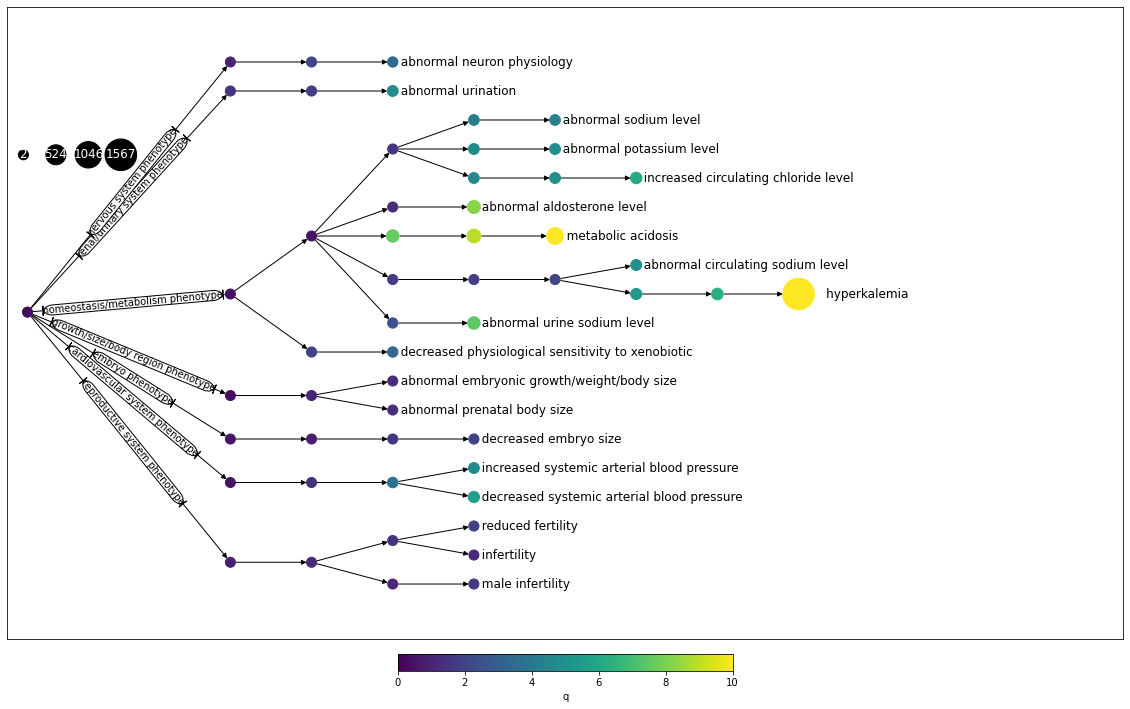

In [76]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C909", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="x",color_by="q", vert=14, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### <a id='toc5_8_6_'></a>[Example 5: Activation of MAPK](#toc0_)

PARENT: MP:0000001 mammalian phenotype


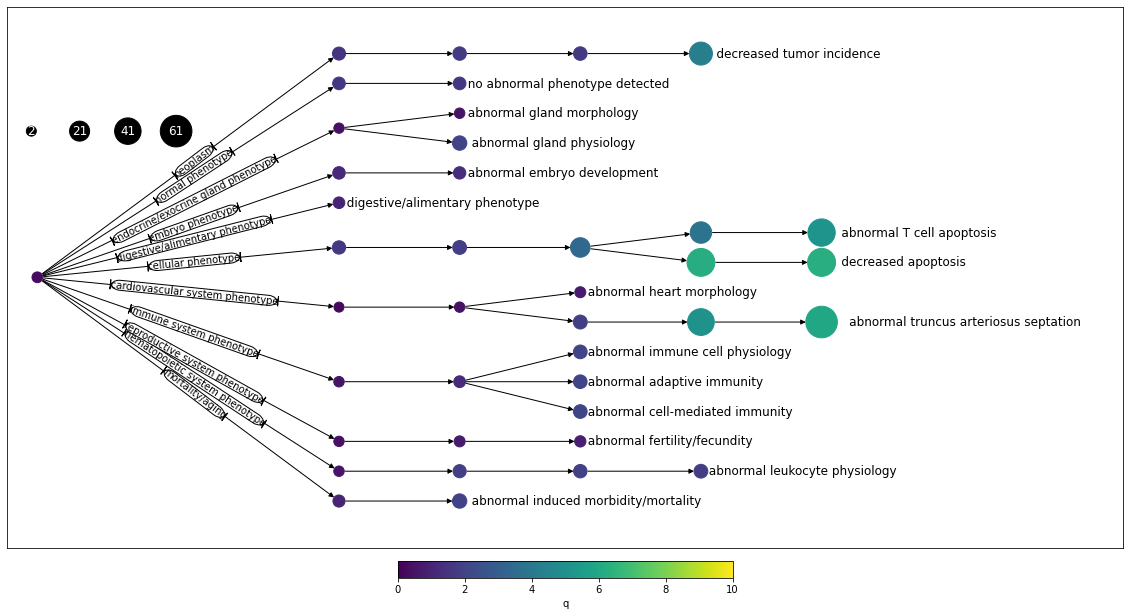

In [77]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C917", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="x",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

## <a id='toc5_9_'></a>[Phenotypes associated with unannotated communties](#toc0_)

We find 5 communities that are enriched for genes related to body size phenotypes that were unannotated for common function via GO. 

To identify potential functional roles of these communities we assess enrichments for gene associated with phenotypes across the mammalian phenotype ontology. For each community we assess enrichment for the 28 highest level phenotype categories and examine subsequent levels of the ontology by keeping only child terms with a higher Positive Predictive Value (PPV) than the parent. 

In [80]:
other_comms = ["C921",  "C914", "C933", "C908"]

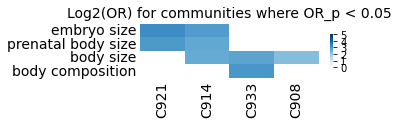

In [81]:
_ = plot_community_heatmap(bmi_pheno_results, body_size_terms, other_comms, annotations=final_annotations, 
                            stat="OR", filter_stat="OR_p", color_range = [0, 5], MPO=MPO, 
                            vert = 1, horz=4, xlabel="annotation", filter_th=0.05,
                            )

In [82]:
skeleton = [5508, 1533]
limbs = [2109]
pigment = [1186]
cardio = [2127,1544 ]
repro = [2160,1919 ]
embryo = [5380]
mortality = [10770, 2083 ]
nervous =[3632, 3633]
integ = [10771]
other_terms = body_size_terms+[num_to_mp(x) for x in nervous+integ+limbs+skeleton+repro+mortality+embryo+cardio+pigment]

In [83]:
other_groups = []
for i, term_list in enumerate([body_size_terms,nervous,integ,limbs,skeleton,repro,mortality,embryo,cardio,pigment]):
    other_groups += [i%2]*len(term_list)

### <a id='toc5_9_1_'></a>[Figure 5B](#toc0_)

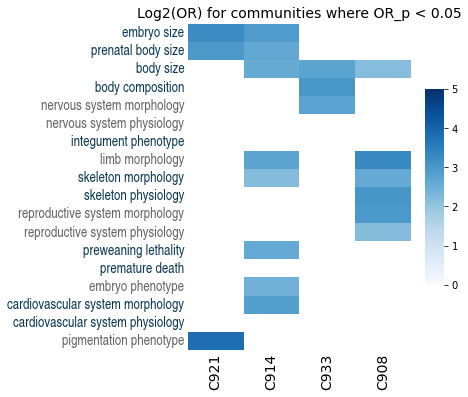

In [84]:
_ = plot_community_heatmap(bmi_pheno_results, other_terms, other_comms, annotations=final_annotations, 
                            stat="OR", filter_stat="OR_p", color_range = [0, 5], MPO=MPO, 
                            vert = 6, horz=5, xlabel="annotation", filter_th=0.05,
                            ylabel_groups=other_groups)
plt.savefig(FIGDIR+"rerun_"*rerun_analysis+"5b_unnamed_community_full_heatmap.png", dpi=400, bbox_inches="tight")

### <a id='toc5_9_2_'></a>[C933](#toc0_)

This community is made up of 5 genes, 4 of which were identified by BMI GWAS in human and one which was identified by rat BMI GWAS. All but AVL9 have phenotypes reported. 

In [85]:
BMI_hier_df.loc["C933"]

CD_MemberList    [AVL9, ARFGEF2, PRKAR1A, KLC1, MSI2]
frac_d1_seeds                                     0.8
frac_d2_seeds                                     0.2
Name: C933, dtype: object

PARENT: MP:0000001 mammalian phenotype


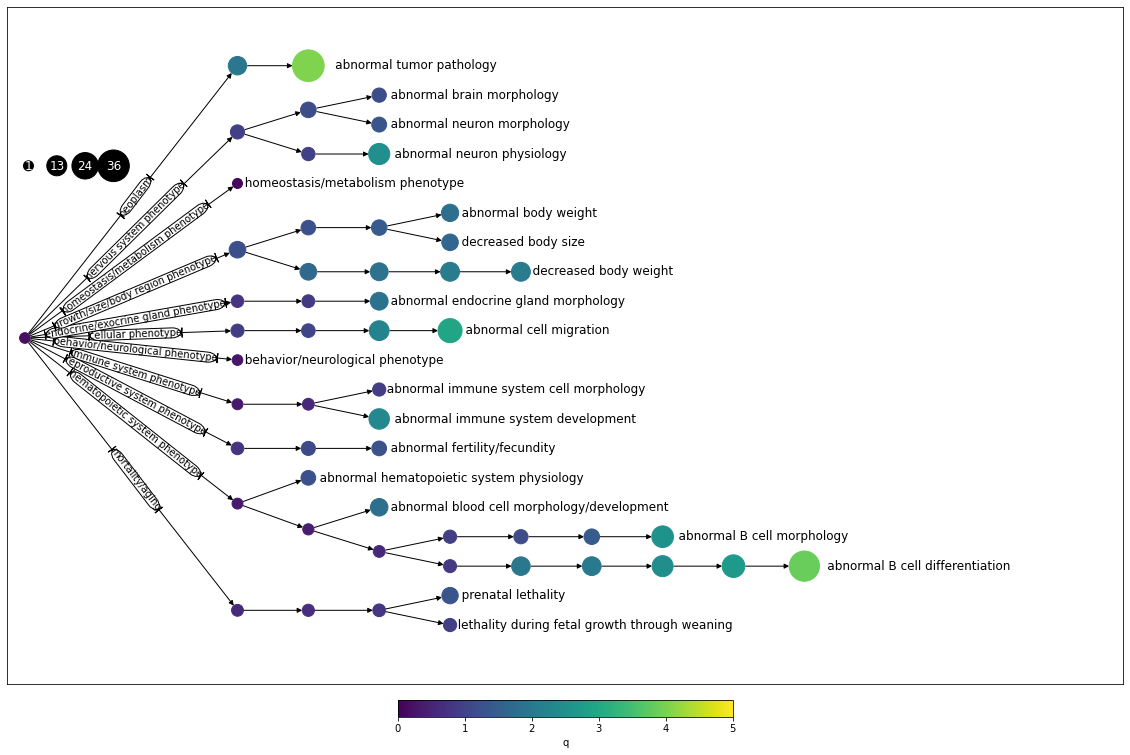

In [86]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C933", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="x",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.4, c_max=5)

### <a id='toc5_9_3_'></a>[C914](#toc0_)

This community is made up of 7 genes, 3 of which were identified by BMI GWAS in human and 1 which was identified by rat BMI GWAS. All have phenotypes in MGD.

In [87]:
BMI_hier_df.loc["C914"]

CD_MemberList    [AXIN1, HHAT, MACF1, SKIL, PLEC, DVL1P1, SKIDA1]
frac_d1_seeds                                            0.428571
frac_d2_seeds                                            0.142857
Name: C914, dtype: object

PARENT: MP:0000001 mammalian phenotype


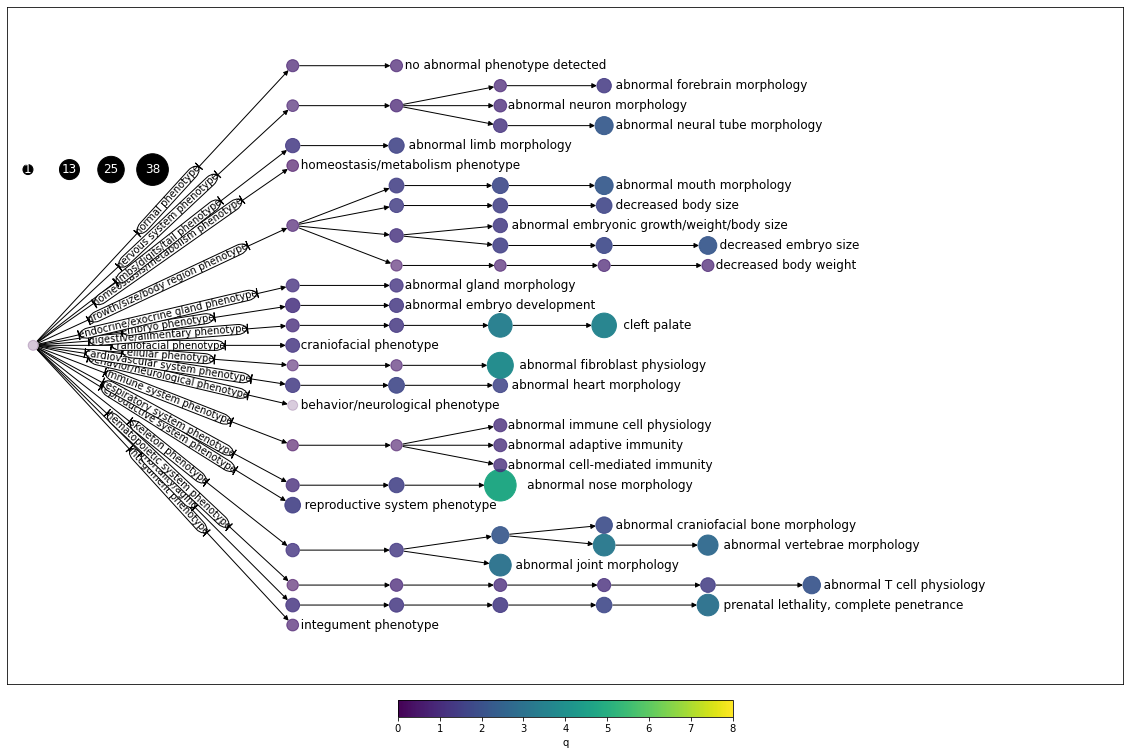

In [88]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C914", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3, c_max=8)

### <a id='toc5_9_4_'></a>[C908](#toc0_)

This community is made up of 8 genes, 3 of which were identified by BMI GWAS in human and 2 which were identified by rat BMI GWAS. 

In [89]:
print(BMI_hier_df.loc["C908"])
print(BMI_hier_df.loc["C908"]["CD_MemberList"])

CD_MemberList    [TOX3, SOX6, SOX5, SOX8, AC105001.2, GAS2, PBL...
frac_d1_seeds                                                0.375
frac_d2_seeds                                                 0.25
Name: C908, dtype: object
['TOX3', 'SOX6', 'SOX5', 'SOX8', 'AC105001.2', 'GAS2', 'PBLD', 'SOX3']


PARENT: MP:0000001 mammalian phenotype


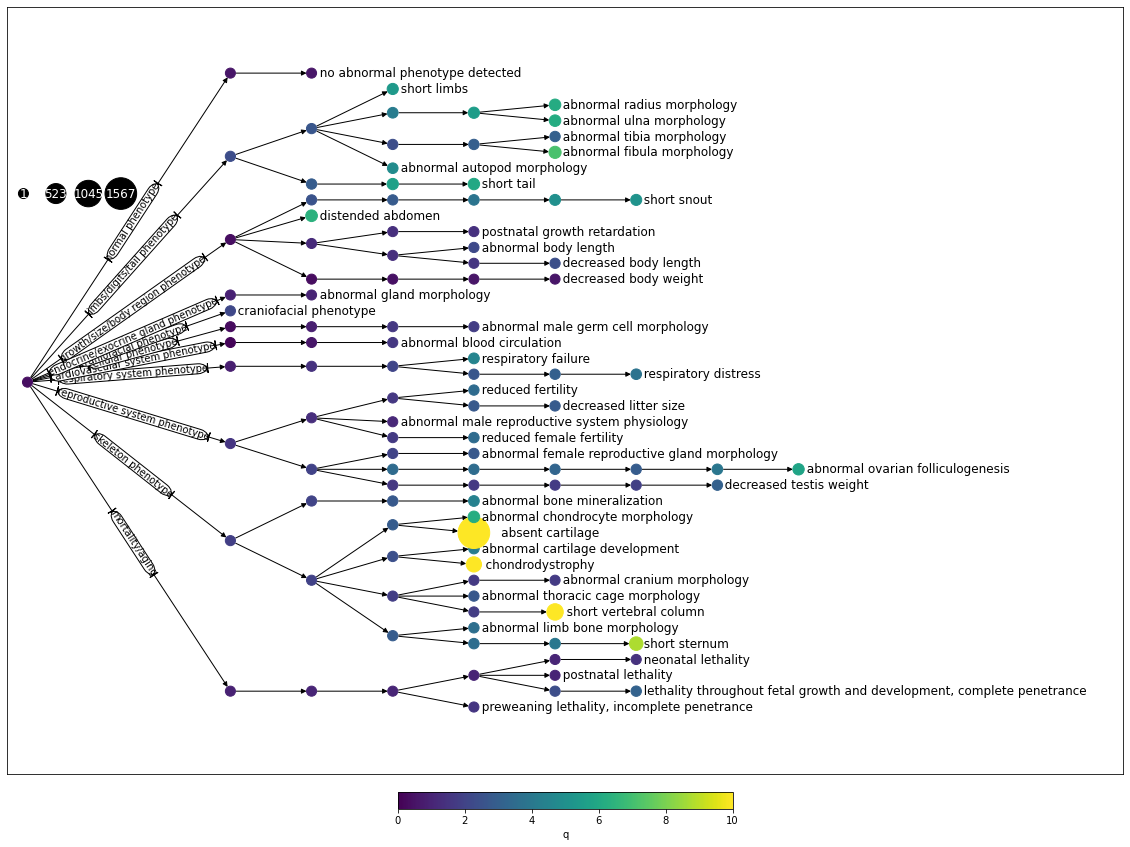

In [90]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C908", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="x",color_by="q", vert=17, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

In [91]:
bmi_pheno_results[bmi_pheno_results["name"]=="C908"].loc["MP:0005451"]

observed                               2
total                               2927
OR                              1.810484
OR_p                             0.46736
OR_CI_lower                     0.365242
OR_CI_upper                     8.974472
hyper_p                         0.114628
sig_5e6                            False
description    abnormal body composition
size                                   8
name                                C908
annotation                          C908
Name: MP:0005451, dtype: object

### <a id='toc5_9_5_'></a>[C921](#toc0_)

This community is made up of 6 genes, 1 which was identified by BMI GWAS in human and 1 which was identified by rat BMI GWAS.

Note: only THAP11 and HCFC1 have phenotypes reported in MGI. 

In [92]:
BMI_hier_df.loc["C921"]

CD_MemberList    [THAP11, HCFC1, THAP2, THAP3, THAP7, THAP4]
frac_d1_seeds                                       0.166667
frac_d2_seeds                                       0.166667
Name: C921, dtype: object

PARENT: MP:0000001 mammalian phenotype


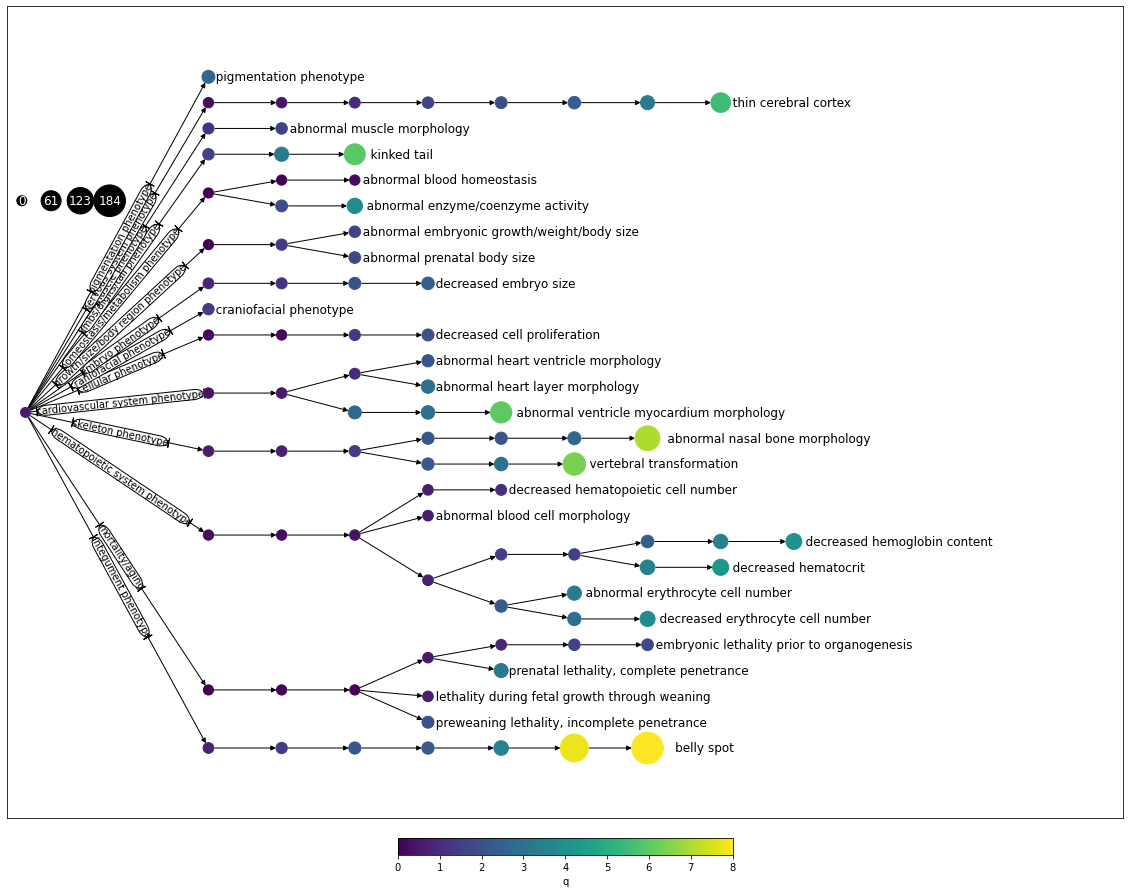

In [93]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C921", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="OR", alpha_by="x",color_by="q", vert=18, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3, c_max=8)

# <a id='toc6_'></a>[Scaled Figures](#toc0_)

Figures produced to scale for manuscript

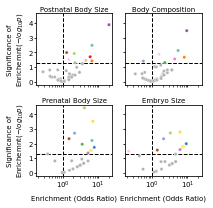

In [94]:
fg = sns.relplot(data=comm_results_body_size, x="OR", y="-log10p", col="description", hue="abbr",
                hue_order=["C908","Root","C914","C933","PP","MAPK","DM1", "DM2", "DM3","CO","C921","GSR",
                "RPA","SS","MSC", "Other"],
                legend=None, palette=my_palette, col_wrap=2, height=1.5, s=10, facet_kws={"despine":False})
fg.set_titles(col_template="")
axs = fg.axes
plt.xscale("log")
titles = ["Postnatal Body Size","Body Composition", "Prenatal Body Size" , "Embryo Size"]
for i, ax in enumerate(axs):
    ax.axvline(1, color="black", linestyle="dashed", zorder=0, lw=1)
    ax.axhline(-1 * np.log10(0.05), color="black", linestyle="dashed", zorder=0, lw=1)
    ax.tick_params(axis='y', pad=1, length=2, labelsize=7)
    ax.tick_params(axis='x', pad=1, length=2, labelsize=7)
    ax.set_ylabel("Significance of\nEnrichemnt($\minus log_{10}p$)", fontsize=7)
    ax.set_xlabel("Enrichment (Odds Ratio)", fontsize=7)
    ax.set_title(titles[i], fontsize=7, pad=2)

fg.tight_layout()
plt.savefig(FIGDIR + "scaled_new_volcano_4.png", dpi=400, bbox_inches="tight")